In [1]:
import numpy as np
from random import randrange
import torch
import matplotlib.pyplot as plt
import math
from matplotlib.colors import Normalize
import fcwt
import papto_functions as papto
import matplotlib.pyplot as plt
import mat73

In [2]:
def symmetric_zero_pad(input_tensor, target_length):
    """
    Apply symmetric zero-padding to a 3D tensor along the last dimension.
    
    Parameters:
    - input_tensor: A tensor of shape [batch_size, 1, L].
    - target_length: The target length after padding.
    
    Returns:
    - A tensor of shape [batch_size, 1, target_length].
    """
    # Current length of the sequences
    current_length = input_tensor.shape[2]
    
    # Calculate the total amount of padding needed
    total_padding = max(target_length - current_length, 0)
    
    # Calculate padding to be added on each side
    padding_left = total_padding // 2
    padding_right = total_padding - padding_left
    
    # Apply symmetric padding
    padded_tensor = torch.nn.functional.pad(input_tensor, (padding_left, padding_right), "constant", 0)
    
    return padded_tensor

def unpad(padded_tensor, original_length):
    """
    Remove symmetric padding from a 3D tensor along the last dimension.
    
    Parameters:
    - padded_tensor: A tensor that has been padded to a target length.
    - original_length: The original length of the sequences before padding.
    
    Returns:
    - A tensor with padding removed, of shape [batch_size, 1, original_length].
    """
    # Current length of the sequences (after padding)
    current_length = padded_tensor.shape[2]
    
    # Calculate the total amount of padding added
    total_padding = current_length - original_length
    
    # Calculate the padding that was added on each side
    padding_left = total_padding // 2
    
    # If there's no padding, return the tensor as is
    if total_padding <= 0:
        return padded_tensor
    
    # Remove symmetric padding
    unpadded_tensor = padded_tensor[:, :, padding_left:padding_left+original_length]
    
    return unpadded_tensor

def min_max_normalization(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def z_score_normalization(data):
    return (data - np.mean(data)) / np.std(data)

def calculated_R_squared(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    SS_tot = np.sum((y_true - y_true_mean) ** 2)
    SS_res = np.sum((y_true - y_pred) ** 2)
    return 1 - SS_res / SS_tot

### Scenario 1-1 (Always)

In [3]:
fpath = 'H:/Simulation_aperiodic/NONOS_v4/Experiment9/bigBW/data_idx/'

exp_num = '9'

result = torch.tensor([])
dataset_x = torch.tensor([])
dataset_y = torch.tensor([])
dataset_idx = torch.tensor([])

for gpu in range(4):
    temp_result = np.load(fpath + 'Experiment' + exp_num + '_result_' + 'gpu' + str(gpu) + '.npy')
    result = torch.cat((result, torch.tensor(temp_result)), 0)

    temp_dataset_x = np.load(fpath + 'Experiment' + exp_num + '_dataset_x_' + 'gpu' + str(gpu) + '.npy')
    dataset_x = torch.cat((dataset_x, torch.tensor(temp_dataset_x)), 0)

    temp_dataset_y = np.load(fpath + 'Experiment' + exp_num + '_dataset_y_' + 'gpu' + str(gpu) + '.npy')
    dataset_y = torch.cat((dataset_y, torch.tensor(temp_dataset_y)), 0)

    temp_dataset_idx = np.load(fpath + 'Experiment' + exp_num + '_dataset_idx_' + 'gpu' + str(gpu) + '.npy')
    dataset_idx = torch.cat((dataset_idx, torch.tensor(temp_dataset_idx)), 0)

result = np.load('H:/Simulation_aperiodic/NONOS_v4/Experiment' + exp_num + '/bigBW/' + 'Experiment' + exp_num + '_result.npy')
dataset_x = np.load('H:/Simulation_aperiodic/NONOS_v4/Experiment' + exp_num + '/bigBW/' + 'Experiment' + exp_num + '_dataset_x.npy')
dataset_y = np.load('H:/Simulation_aperiodic/NONOS_v4/Experiment' + exp_num + '/bigBW/' + 'Experiment' + exp_num + '_dataset_y.npy')

In [4]:
fs = 100
t_len = 20
data_len = fs*t_len
time = np.linspace(0, t_len, fs*t_len)
lb_idx = 0#int(0.5*fs)
ub_idx = 20*fs

### LPF

In [5]:
from scipy.signal import firwin, lfilter, firwin, freqz, group_delay, filtfilt
from scipy.signal import butter, filtfilt

cutoff_freq = [4]

# Define the filter order
order = 4

# Calculate the normalized cutoff frequency
normalized_cutoff_freq = [freq / (fs / 2) for freq in cutoff_freq]

# Design the Butterworth filter
b, a = butter(order, normalized_cutoff_freq, btype='low')

x_org = unpad(torch.tensor(dataset_x), data_len).numpy()
LPF = np.zeros((x_org.shape[0], x_org.shape[1], x_org.shape[2]))

for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        x = x_org[i, j, :]
        LPF[i, j, :] = filtfilt(b, a, x)


## BPF

In [6]:
# np.save('/home/Documents/Data/x_org.npy', x_org) # data extract for MATLAB code

# MATLAB code belows
##################################
# fpath = "/home/Documents/Data/"
# fs = 100;

# x_org = readNPY(strcat(fpath, 'x_org.npy'));

# x_bp = single(zeros(52, 1, 2000));

# cutoff_freq = [0.5 4];
# order = 3300;
# bpFilt = fir1(order, cutoff_freq./(fs/2)); % bandpass filteringw using hamming window
# D = mean(grpdelay(bpFilt));

# for i = 1:52
#     x_filt = filter(bpFilt, 1, [squeeze(x_org(i, :, :)); zeros(D, 1)]); % Append D zeros to the input data
#     x_filt = x_filt(D+1:end);                  % Shift data to compensate for delay
#     x_bp(i, :, :) = x_filt;
# end

# writeNPY(x_bp, strcat(fpath, 'x_bp.npy'));
##################################

BPF = np.load('H:/Simulation_aperiodic/NONOS_v4/Experiment9/x_bp_from1Hz.npy')

### NONOS

In [7]:
cue_time = 10
fake_x_ap = result

cutoff_freq = [4]

# Define the filter order
order = 4

# Calculate the normalized cutoff frequency
normalized_cutoff_freq = [freq / (fs / 2) for freq in cutoff_freq]

# Design the Butterworth filter
b, a = butter(order, normalized_cutoff_freq, btype='low')

temp_fake_x_ap = result
temp_x = dataset_x
temp_x = unpad(torch.tensor(temp_x), data_len).numpy()

fake_x_p_LPF = np.zeros((temp_x.shape[0], temp_x.shape[1], temp_x.shape[2]))

print(temp_fake_x_ap.shape)
print(temp_x.shape)

for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        x = temp_x[i, j, :] - temp_fake_x_ap[i, j, :]
        fake_x_p_LPF[i, j, :] = filtfilt(b, a, x)

(52, 1, 2000)
(52, 1, 2000)


## Wavelet Transform ##

Wake -> Sleep


(array([1, 2, 3, 4]),
 [Text(0, 1, '1'), Text(0, 2, '2'), Text(0, 3, '3'), Text(0, 4, '4')])

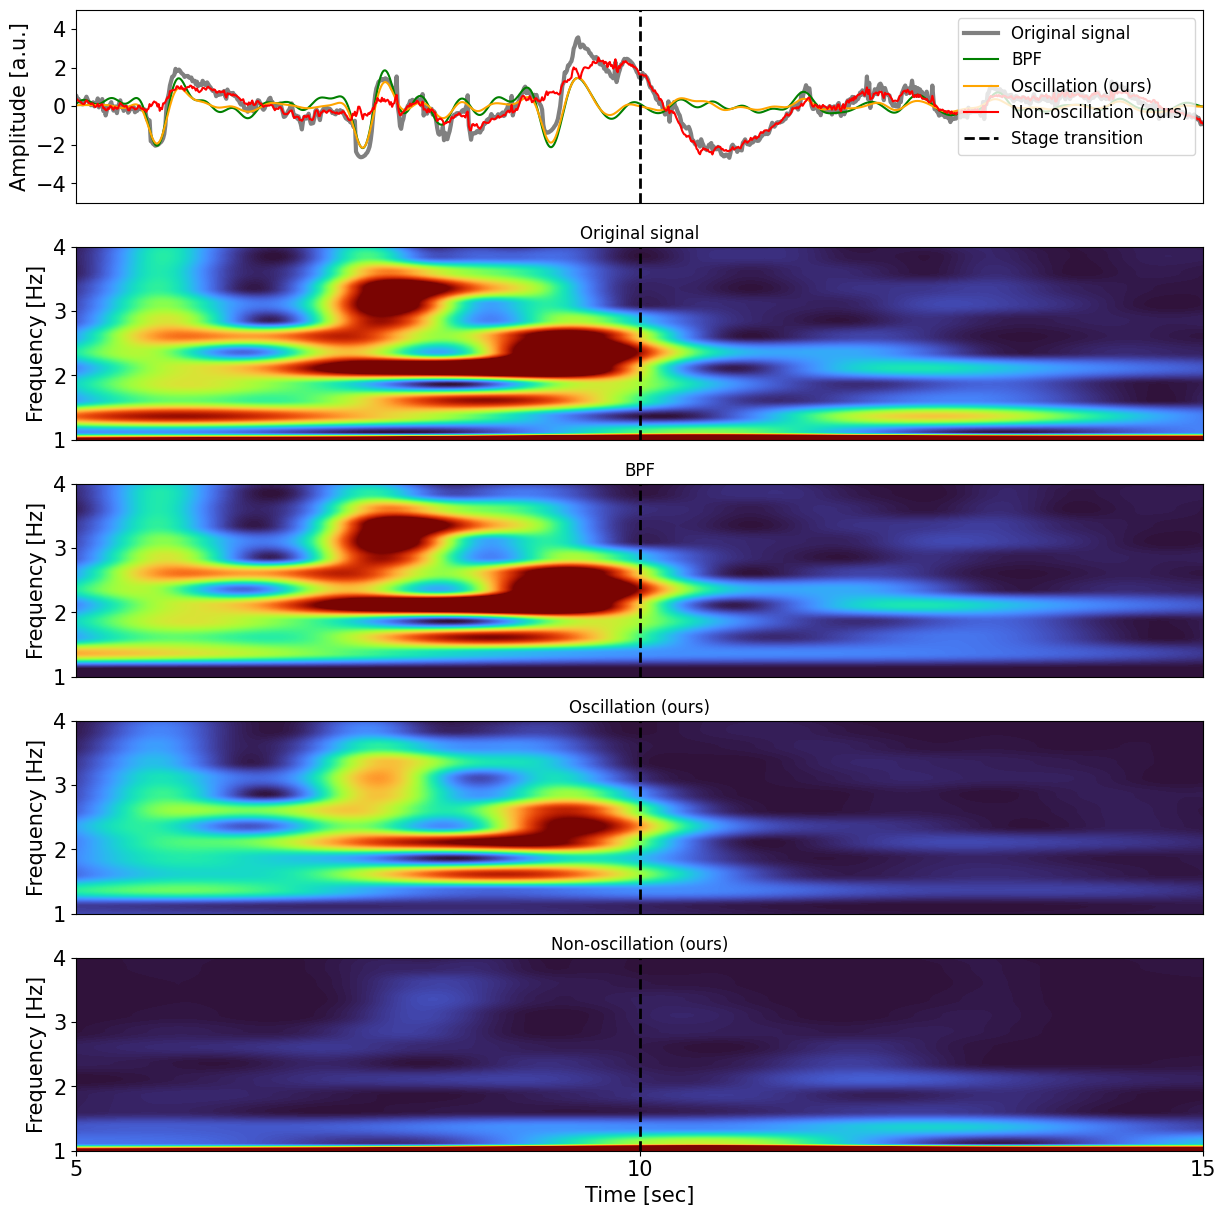

In [8]:
### LPF + fake_x_p
data_idx = 24 # 24
y_data = dataset_y[data_idx]
print('Sleep -> Wake' if y_data == 2 else 'Wake -> Sleep')

org_x = unpad(torch.tensor(dataset_x), data_len).numpy().squeeze()

# fake_x_ap_before = fake_x_ap[data_idx, :, lb_idx:cue_time*fs]
NONOS_before = fake_x_p_LPF[data_idx, :, lb_idx:cue_time*fs]
NONOS_after = fake_x_p_LPF[data_idx, :, cue_time*fs:ub_idx]
NONOS_cat = np.concatenate((NONOS_before, NONOS_after), axis=1)
NONOS_cat_wo_LPF = temp_x - temp_fake_x_ap
NONOS_cat_wo_LPF = NONOS_cat_wo_LPF[data_idx, :, :]

NONOS_nosc = temp_fake_x_ap[data_idx, :, :]

# Simple LPF
LPF_before = LPF[data_idx, :, lb_idx:cue_time*fs]
LPF_after = LPF[data_idx, :, cue_time*fs:ub_idx]
LPF_cat = np.concatenate((LPF_before, LPF_after), axis=1)

BPF_before = BPF[data_idx, :, lb_idx:cue_time*fs]
BPF_after = BPF[data_idx, :, cue_time*fs:ub_idx]
BPF_cat = np.concatenate((BPF_before, BPF_after), axis=1)

# PAPTO's wavelet for x_org
fs = 100
n = fs*20
f0 = .5 #lowest frequency
f1 = fs//2 #highest frequency
fn = fs*2 #number of frequencies

fmin = 0.25
fmax = fs//2
fstep = 0.25
fVec = np.arange(fmin, fmax, fstep)

temp_org = org_x[data_idx, :]
temp_org = np.expand_dims(temp_org, axis=0)
TFR_org, tVEC = papto.TFR_via_morlet_wavelet(temp_org, fs, fVec)

# PAPTO's wavelet for BPF
fmin = 0.25
fmax = fs//2
fstep = 0.25
fVec = np.arange(fmin, fmax, fstep)

temp_BPF = BPF_cat.squeeze()
temp_BPF = np.expand_dims(temp_BPF, axis=0)
TFR_BPF, tVEC = papto.TFR_via_morlet_wavelet(temp_BPF, fs, fVec)

# PAPTO's wavelet for NONOS's oscillation
fmin = 0.25
fmax = fs//2
fstep = 0.25
fVec = np.arange(fmin, fmax, fstep)

temp_osc = NONOS_cat.squeeze()
temp_osc = np.expand_dims(temp_osc, axis=0)
TFR_osc, tVEC = papto.TFR_via_morlet_wavelet(temp_osc, fs, fVec)

# PAPTO's wavelet for NONOS's non-oscillation
fmin = 0.25
fmax = fs//2
fstep = 0.25
fVec = np.arange(fmin, fmax, fstep)

temp_nosc = fake_x_ap[data_idx, :, :].squeeze()
temp_nosc = np.expand_dims(temp_nosc, axis=0)
TFR_nosc, tVEC = papto.TFR_via_morlet_wavelet(temp_nosc, fs, fVec)

all_data = np.concatenate((TFR_org[0].flatten(), TFR_BPF[0].flatten(), TFR_osc[0].flatten(), TFR_nosc[0].flatten()))
global_min = all_data.min()
global_max = all_data.max()

norm = Normalize(vmin=global_min, vmax=global_max*0.1)

time_lb = 5
time_ub = 15
freq_lb = 1
freq_ub = 4

y_scale = 'linear'

# Plot
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 12))
plt.tight_layout()
plt.subplot(5, 1, 1)
time = np.linspace(0, 20, 20*fs)
ax1.plot(time, org_x[data_idx, :], color='gray', label='fake_x_ap', linewidth=3)
ax1.plot(time, BPF_cat[0, :], color='green', label='BPF_cat')
ax1.plot(time, NONOS_cat[0, :], color='orange', label='NONOS_osc')
ax1.plot(time, NONOS_nosc[0, :], color='r', label='NONOS_osc')
ax1.axvline(x=10, color='k', linestyle='--', linewidth=2)
plt.ylabel('Amplitude [a.u.]', fontsize=15)
plt.legend(['Original signal', 'BPF', 'Oscillation (ours)', 'Non-oscillation (ours)', 'Stage transition'], loc='upper right', fontsize=12)
plt.xlim([time_lb, time_ub])
plt.ylim([-5, 5])
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15)

plt.subplot(5, 1, 2)
ax2.imshow((TFR_org[0]), extent=[0, n/fs, f0, f1], norm=norm, cmap='turbo', origin='lower', aspect='auto')
# plt.imshow(np.abs(out), extent=[0, n/fs, f0, f1], aspect='auto', cmap='turbo', vmin=vmin, vmax=60)
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlim([time_lb, time_ub])
plt.ylim([freq_lb, freq_ub])
plt.axvline(x=10, color='k', linestyle='--', linewidth=2)
plt.ylabel('Frequency [Hz]', fontsize=15)
ax2.get_xaxis().set_visible(False)
ax2.set_yscale(y_scale)
ax2.title.set_text('Original signal')
ax2.set_yticks([1, 2, 3, 4])
plt.yticks(fontsize=15)

plt.subplot(5, 1, 3)
ax3.imshow((TFR_BPF[0]), extent=[0, n/fs, f0, f1], norm=norm, cmap='turbo', origin='lower', aspect='auto')
# plt.imshow(np.abs(out), extent=[0, n/fs, f0, f1], aspect='auto', cmap='jet')
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlim([time_lb, time_ub])
plt.ylim([freq_lb, freq_ub])
plt.axvline(x=10, color='k', linestyle='--', linewidth=2)
ax3.get_xaxis().set_visible(False)
ax3.set_yscale(y_scale)
ax3.title.set_text('BPF')
ax3.set_yticks([1, 2, 3, 4])
plt.yticks(fontsize=15)

plt.subplot(5, 1, 4)
ax4.imshow((TFR_osc[0]), extent=[0, n/fs, f0, f1], norm=norm, cmap='turbo', origin='lower', aspect='auto')
# plt.imshow(np.abs(out), extent=[0, n/fs, f0, f1], aspect='auto', cmap='jet')
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlim([time_lb, time_ub])
plt.ylim([freq_lb, freq_ub])
plt.axvline(x=10, color='k', linestyle='--', linewidth=2)
ax4.get_xaxis().set_visible(False)
ax4.set_yscale(y_scale)
ax4.title.set_text('Oscillation (ours)')
ax4.set_yticks([1, 2, 3, 4])
plt.yticks(fontsize=15)

plt.subplot(5, 1, 5)
ax5.imshow((TFR_nosc[0]), extent=[0, n/fs, f0, f1], norm=norm, cmap='turbo', origin='lower', aspect='auto')
# plt.imshow(np.abs(out), extent=[0, n/fs, f0, f1], aspect='auto', cmap='jet')
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlim([time_lb, time_ub])
plt.ylim([freq_lb, freq_ub])
plt.axvline(x=10, color='k', linestyle='--', linewidth=2)
plt.xticks(fontsize=15)
ax5.set_xticks([5, 10, 15])
plt.xlabel('Time [sec]', fontsize=15)
ax5.set_yscale(y_scale)
ax5.title.set_text('Non-oscillation (ours)')
ax5.set_yticks([1, 2, 3, 4])
plt.yticks(fontsize=15)

In [15]:
# Time domain
np.save('D:/Github/PINN_NONOS/org_x.npy', org_x[data_idx, :])
np.save('D:/Github/PINN_NONOS/BPF.npy', BPF_cat[0, :])
np.save('D:/Github/PINN_NONOS/NONOS_osc.npy', NONOS_cat[0, :])
np.save('D:/Github/PINN_NONOS/NONOS_nosc.npy', NONOS_nosc[0, :])
np.save('D:/Github/PINN_NONOS/time.npy', time)



## NONOS vs. BPF in the frequency domain ##

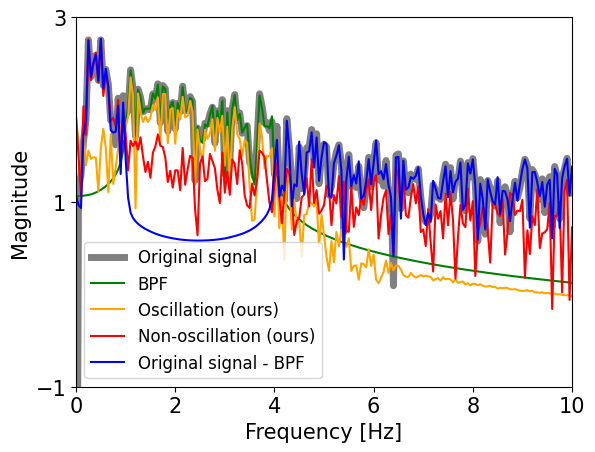

In [9]:
delta_subtracted_x = org_x[data_idx, :] - BPF_cat[0, :]

fft_org_x = np.fft.rfft(org_x[data_idx, :])
fft_BPF = np.fft.rfft(BPF_cat[0, :])
fft_osc = np.fft.rfft(NONOS_cat[0, :])
fft_nosc = np.fft.rfft(NONOS_nosc[0, :])
fft_ds_x = np.fft.rfft(delta_subtracted_x)

freqs = np.fft.rfftfreq(len(org_x[data_idx, :]), 1/fs)

fig = plt.figure()
plt.plot(freqs, np.log10(np.abs(fft_org_x)), color='gray', label='Original signal', linewidth=5)
plt.plot(freqs, np.log10(np.abs(fft_BPF)), color='green', label='BPF')
plt.plot(freqs, np.log10(np.abs(fft_osc)), color='orange', label='Oscillation (ours)')
plt.plot(freqs, np.log10(np.abs(fft_nosc)), color='r', label='Non-oscillation (ours)')
plt.plot(freqs, np.log10(np.abs(fft_ds_x)), color='b', label='Delta-subtracted signal')
plt.xlim([0, 10])
plt.ylim([-1, 3])
plt.xlabel('Frequency [Hz]', fontsize=15)
plt.ylabel('Magnitude', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-1, 1, 3])
plt.legend(['Original signal', 'BPF', 'Oscillation (ours)', 'Non-oscillation (ours)', 'Original signal - BPF'], loc='lower left', fontsize=12)

## Additional baseline, SPRiNT [https://doi.org/10.7554/eLife.77348]

In [10]:
temp_x = org_x

before_x = temp_x[data_idx, :]
after_x = temp_x[data_idx, :]

before_x = torch.tensor(before_x)
after_x = torch.tensor(after_x)
temp_x = torch.cat((before_x, after_x), dim=0)

In [11]:
# Extraction numpy for MATLAB code
np.save('H:/Simulation_aperiodic/NONOS_v4/Experiment9/bigBW/data24.npy', temp_x.numpy())
# Please see the MATLAB code, "SPRiNT_NONOS_v0a.m" for extract the .mat files

Text(0, 0.5, '[a.u.]')

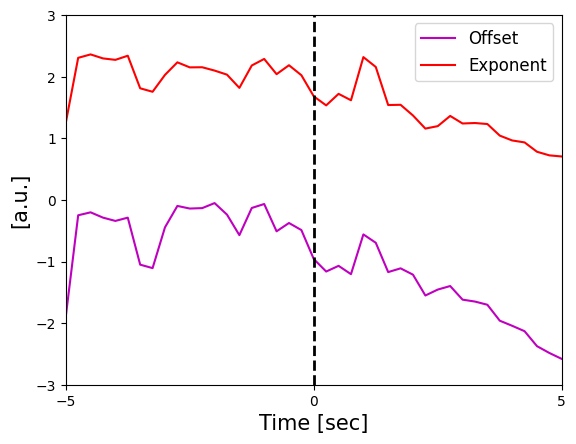

In [12]:
fpath = 'H:/Simulation_aperiodic/NONOS_v4/Experiment9/bigBW/'
sprint_offset = mat73.loadmat(fpath + 'SPRiNT_offset.mat')
sprint_offset = sprint_offset['offset']

sprint_exponent = mat73.loadmat(fpath + 'SPRiNT_exponent.mat')
sprint_exponent = sprint_exponent['exponent']

sprint_time = mat73.loadmat(fpath + 'SPRiNT_time.mat')
sprint_time = sprint_time['time']

indices = np.where((sprint_time >= 5) & (sprint_time <= 15))[0]

color1 = (0,	0.447000000000000,	0.741000000000000)
color2 = (0.929000000000000,	0.694000000000000,	0.125000000000000)

fig = plt.figure()

plt.plot(sprint_time[indices]-10, sprint_offset[indices], color='m', label='Offset')
plt.plot(sprint_time[indices]-10, sprint_exponent[indices], color='r', label='Exponent')
plt.ylim([-3, 3])
plt.xlim([-5, 5])
plt.xticks([-5, 0, 5])
plt.axvline(x=0, color='k', linestyle='--', linewidth=2)
plt.legend(['Offset', 'Exponent'], loc='upper right', fontsize=12)
plt.xlabel('Time [sec]', fontsize=15)
plt.ylabel('[a.u.]', fontsize=15)